In [5]:
from earlyexitnet.training_tools.train import get_model
from earlyexitnet.tools import load_model, CIFAR10DataColl
import torch

model_path = '../../earlyexitnet/trained_models/b_lenet_cifar10.pth'
model_name = "b_lenet_cifar"

# model_path = '../../earlyexitnet/trained_models/resnet8_2ee_230721.pth'
# model_name = "resnet8_2ee"
model = get_model(model_name)
load_model(model, model_path,device=torch.device('cuda:0'))

Model done: b_lenet_cifar


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

BATCH_SIZE = 1000

datacoll = CIFAR10DataColl(batch_size_train=BATCH_SIZE, v_split=0.2)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
from earlyexitnet.testing_tools.test import Tester
import json
from datetime import datetime as dt

def compute_and_savevalues():
  train_dl = datacoll.get_train_dl()
  tester = Tester(model, train_dl, exits=2, comp_funcs=[], device=torch.device('cuda:0'), save_raw=True)

  tester.test()

  test_res = tester.get_stats()

  ts = dt.now().strftime("%Y-%m-%d_%H%M%S")

  with open(f'../model-outputs/{model_name}_cifar10_raw_train_output_{ts}.json','a') as file:
    file.write(json.dumps(test_res))
  return test_res

In [2]:
import json
loadFromFile = True
if loadFromFile:
  json_file = '../model-outputs/resnet8_2ee_cifar10_raw_train_output_280723-12-18.json'
  with open(json_file) as json_data:
    test_res = json.load(json_data)
else:
  test_res = compute_and_savevalues()  


raw_results = torch.Tensor(test_res['raw_layer'])
correct_indices = torch.Tensor(test_res['true_indices'])

correct_predictions = (raw_results.argmax(-1) == correct_indices)
correct_predictions.shape

torch.Size([2, 40000])

In [7]:
import helper.graphs as hp

classes_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rr = raw_results.numpy()
flattened = np.asarray([[y[i] for i in range(10) for y in x] for x in rr])
correct_class = np.asarray([[y for i in range(10) for y in x] for x in np.argmax(rr, -1)])
class_index = np.asarray([[i for i in range(10) for y in x] for x in np.argmax(rr, -1)])
misclassified = np.asarray([[y for i in range(10) for y in x] for x in correct_predictions])

comb = np.stack((class_index,
                 flattened, 
                 correct_class,
                 misclassified),-1)

classes_grouped = hp.group_by(comb)

(40000, 3)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

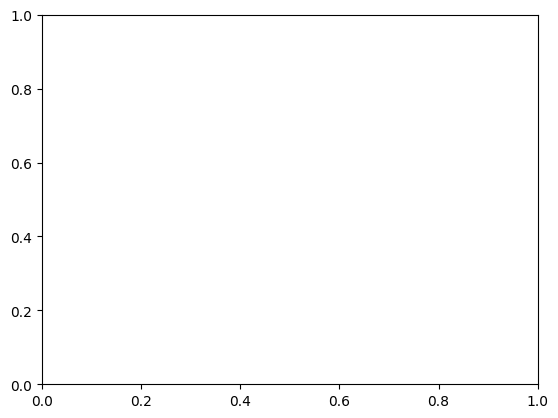

In [12]:
import helper.graphs as hp
from importlib import reload
reload(hp)

early_exit = classes_grouped[0]
# print(early_exit[0])
for i, rec_class in enumerate(early_exit):
  fig, ax = plt.subplots(nrows=1,ncols=1)
  rec_class = np.array(rec_class)
  
  # plot all values produce by single class output
  # hp.plot_right_wrong(ax, np.array(rec_class[:,0]),(np.array(rec_class[:,1]) == i), quants=None)

  # wrong_class = rec_class[np.invert(np.array(rec_class[:,2],dtype=bool))]
  # # hp.plot_right_wrong(ax, np.array(rec_class[:,0]),(np.array(rec_class[:,1]) == i), quants=None, right_col='green', wrong_col='orange')
  # ismax = np.array(wrong_class[:,1]) == i
  # hp.plot_hist_kernel(ax, wrong_class[:,0][ismax], label=f"{i} {classes_labels[i]} wrong", hist=False)
  # right_class = rec_class[np.array(rec_class[:,2],dtype=bool)]
  # # hp.plot_right_wrong(ax, np.array(rec_class[:,0]),(np.array(rec_class[:,1]) == i), quants=None, right_col='green', wrong_col='orange')
  # ismax = np.array(right_class[:,1]) == i
  # hp.plot_hist_kernel(ax, right_class[:,0][ismax], label=f"{i} {classes_labels[i]} right", hist=False, ls='-')
  # ax.set_title(f"{i} {classes_labels[i]}")
  ax.legend()
plt.show()

In [8]:
# SHOW THE MODEL WORKING

# %matplotlib ipympl needs ipywidgets
import math
from IPython.core.debugger import set_trace

test_dl = datacoll.get_train_dl()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img, ncols=1, label=None, caption=None):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    num_img = npimg.shape[0]
    
    nrows = math.ceil(num_img / ncols)
    
    img_track = 0
    
    for row in range(nrows):
        fig, axs = plt.subplots(nrows=1, ncols=ncols,
                                subplot_kw={'xticks': [], 'yticks': []})
        
        for ax in axs:
            if img_track < num_img:
                ax.imshow(np.transpose(npimg[img_track], (1, 2, 0)))
                if label is not None:
                    ax.set_title(label[img_track])
                if caption is not None:
                    ax.set_xlabel(caption[img_track])
            img_track += 1
            
        plt.tight_layout()
        # plt.imshow(np.transpose(npimg, (1, 1, 1)))
        plt.show()

def getcaption(images, model):
    model.eval()
    captions = ['' for i in range(BATCH_SIZE)]
    with torch.no_grad():
        result = model.forward(images)
        sftmx = torch.max(torch.softmax(result, dim=-1),dim=-1).values
        res_max = result.max(dim=-1).values
        res_arg_max = result.max(dim=-1).indices
        for exit_num, (max, arg_max) in enumerate(zip(sftmx, res_arg_max)):
            for i, (max_val, index) in enumerate(zip(max, arg_max)):
                captions[i] += f"e{exit_num} {classes[index]:5s} {max_val:.02f}"
                if exit_num != model.exit_num - 1:
                    captions[i] += '\n'
    return captions
# get some random training images
dataiter = iter(test_dl)
images, labels = next(dataiter)


# show images
imshow(images, ncols=4, label=[f'{classes[label]:5s}' for label in labels], caption=getcaption(images, model))


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

: 